In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
from sklearn.preprocessing import LabelEncoder
def load_dataset(dataset_id):
    # Load a file, assuming the first (N - 1) columns are features, and the last column is the target value
    path = Path(f'data/uci/{dataset_id}')
    df = pd.read_csv(path / 'data.txt')
    arr = df.to_numpy()
    X, y = arr[:, :-1], arr[:, -1]
    le = LabelEncoder()
    return X, le.fit_transform(y)

In [3]:
X, y = load_dataset(94)  # Spambase
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape

(3680, 57)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

def get_final_predictions(samples, wb, bb, grades):
    wb_predictions = wb.predict(samples)
    bb_predictions = bb.predict(samples)
    
    hard_idx = grades == True
    final_predictions = wb_predictions.copy()
    final_predictions[hard_idx] = bb_predictions[hard_idx]
    
    return final_predictions


In [27]:
white_box = DecisionTreeClassifier(max_depth=4)
white_box.fit(X_train, y_train)

black_box = XGBClassifier()
black_box.fit(X_train, y_train)

is_hard = white_box.predict(X_train) != y_train
smote = SMOTE(random_state=0)
X2, y2 = smote.fit_resample(X_train, is_hard)
grader = DecisionTreeClassifier(max_depth=4)
grader.fit(X2, y2)

print('(Training)')
grades_train = grader.predict(X_train)
final_predictions_train = get_final_predictions(X_train, white_box, black_box, grades_train)
print(f'{(np.sum(final_predictions_train == y_train) / X_train.shape[0]):.4f} -- {(np.sum(grades_train) / X_train.shape[0]):.4f}')

print('(Testing)')
grades_test = grader.predict(X_test)
final_predictions_test = get_final_predictions(X_test, white_box, black_box, grades_test)
print(f'{(np.sum(final_predictions_test == y_test) / X_test.shape[0]):.4f} -- {(np.sum(grades_test) / X_test.shape[0]):.4f}')

(Training)
0.9728 -- 0.3125
(Testing)
0.9262 -- 0.3160


## Try to control the deferral rate by changing class weights

In [ ]:
from src.models import OptunaXGBoost

datasets = {
    17: 'Breast Cancer (Wisconsin)',
    19: 'Car',
    52: 'Ionosphere',
    59: 'Letter',
    94: 'Spambase',
    267: 'Banknote',
}
n = 1_001

for dataset_id, dataset_name in datasets.items():
    X, y = load_dataset(dataset_id)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    results = np.zeros(shape=(n, 2, 2))  # Resampling rate, Train/Test, Accuracy/Deferral 
    white_box = DecisionTreeClassifier(max_depth=4)
    white_box.fit(X_train, y_train)
    
    #black_box = OptunaXGBoost(n_trials=300)
    black_box = XGBClassifier()
    black_box.fit(X_train, y_train)
    
    is_hard = white_box.predict(X_train) != y_train
    smote = SMOTE(random_state=0)
    X2, y2 = smote.fit_resample(X_train, is_hard)
    
    for i in range(n):
        grader = DecisionTreeClassifier(max_depth=None, class_weight={
            True: i,
            False: n - i - 1,
        })
        grader.fit(X2, y2)
        
        grades_train = grader.predict(X_train)
        final_predictions_train = get_final_predictions(X_train, white_box, black_box, grades_train)
        results[i, 0, 0] = np.sum(final_predictions_train == y_train) / X_train.shape[0]
        results[i, 0, 1] = np.sum(grades_train) / X_train.shape[0]
        
        grades_test = grader.predict(X_test)
        final_predictions_test = get_final_predictions(X_test, white_box, black_box, grades_test)
        results[i, 1, 0] = np.sum(final_predictions_test == y_test) / X_test.shape[0]
        results[i, 1, 1] = np.sum(grades_test) / X_test.shape[0]

    default_grader = DecisionTreeClassifier(max_depth=None)
    default_grader.fit(X2, y2)
    default_grades_train = default_grader.predict(X_train)
    default_predictions_train = get_final_predictions(X_train, white_box, black_box, default_grades_train)
    default_grades_test = default_grader.predict(X_test)
    default_predictions_test = get_final_predictions(X_test, white_box, black_box, default_grades_test)
        
    fig, ax = plt.subplots(figsize=(9, 9), nrows=2, ncols=2)
    fig.suptitle(f'{dataset_name}', fontsize=18)
    
    acc_min = np.max([np.min(results[:, :, 0]) - 0.05, 0])
    acc_max = np.min([np.max(results[:, :, 0]) + 0.05, 1.01])
    
    ax[0, 0].set_title('Deferral vs. Accuracy -- Training')
    ax[0, 0].set_xlim([0, 1])
    ax[0, 0].set_xlabel('Deferral Rate')
    ax[0, 0].set_ylim([acc_min, acc_max])
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].scatter(x=results[:, 0, 1], y=results[:, 0, 0])
    ax[0, 0].scatter(
        x=np.sum(default_grades_train) / X_train.shape[0],
        y=(np.sum(default_predictions_train == y_train)) / X_train.shape[0],
        c='red', s=400, marker='*',
    )
    
    ax[0, 1].set_title('Deferral vs. Accuracy -- Testing')
    ax[0, 1].set_xlim([0, 1])
    ax[0, 1].set_xlabel('Deferral Rate')
    ax[0, 1].set_ylim([acc_min, acc_max])
    ax[0, 1].set_ylabel('Accuracy')
    ax[0, 1].scatter(x=results[:, 1, 1], y=results[:, 1, 0])
    ax[0, 1].scatter(
        x=np.sum(default_grades_test) / X_test.shape[0],
        y=(np.sum(default_predictions_test == y_test)) / X_test.shape[0],
        c='red', s=400, marker='*',
    )
    
    ax[1, 0].set_title('Weight vs. Deferral -- Training')
    ax[1, 0].set_xlabel('Weight (Hard Patterns)')
    ax[1, 0].set_ylim([-0.01, 1.01])
    ax[1, 0].set_ylabel('Deferral Rate')
    ax[1, 0].scatter(x=np.arange(n) / n, y=results[:, 0, 1])
    
    ax[1, 1].set_title('Weight vs. Deferral -- Testing')
    ax[1, 1].set_xlabel('Weight (Hard Patterns)')
    ax[1, 1].set_ylim([-0.01, 1.01])
    ax[1, 1].set_ylabel('Deferral Rate')
    ax[1, 1].scatter(x=np.arange(n) / n, y=results[:, 1, 1])
    
    plt.show();


In [100]:
np.max(results[:, :, 0])

np.float64(0.9967391304347826)

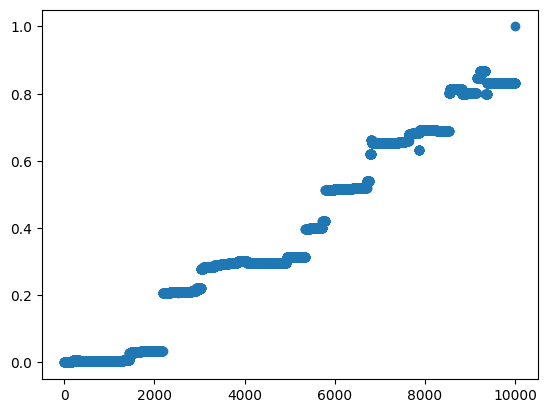

In [83]:
plt.scatter(x=np.arange(n), y=results[:, 0, 1])

## Now, can we target a specific deferral rate?

In [56]:
## This part actually stays the same!!
n = 250
results = np.zeros(shape=(n, 2, 2))  # Resampling rate, Train/Test, Accuracy/Deferral 
white_box = DecisionTreeClassifier(max_depth=6)
white_box.fit(X_train, y_train)

black_box = XGBClassifier()
black_box.fit(X_train, y_train)

is_hard = white_box.predict(X_train) != y_train
smote = SMOTE(random_state=0)
X2, y2 = smote.fit_resample(X_train, is_hard)

for i in range(n):
    grader = DecisionTreeClassifier(max_depth=4, class_weight={
        True: i,
        False: n - i - 1,
    })
    grader.fit(X2, y2)
    
    grades_train = grader.predict(X_train)
    final_predictions_train = get_final_predictions(X_train, white_box, black_box, grades_train)
    results[i, 0, 0] = np.sum(final_predictions_train == y_train) / X_train.shape[0]
    results[i, 0, 1] = np.sum(grades_train) / X_train.shape[0]
    
    grades_test = grader.predict(X_test)
    final_predictions_test = get_final_predictions(X_test, white_box, black_box, grades_test)
    results[i, 1, 0] = np.sum(final_predictions_test == y_test) / X_test.shape[0]
    results[i, 1, 1] = np.sum(grades_test) / X_test.shape[0]

In [69]:
results[:3, 0, 1]

array([0.        , 0.00081522, 0.00081522])

In [70]:
results[-3:, 0, 1]

array([0.83288043, 0.83288043, 1.        ])

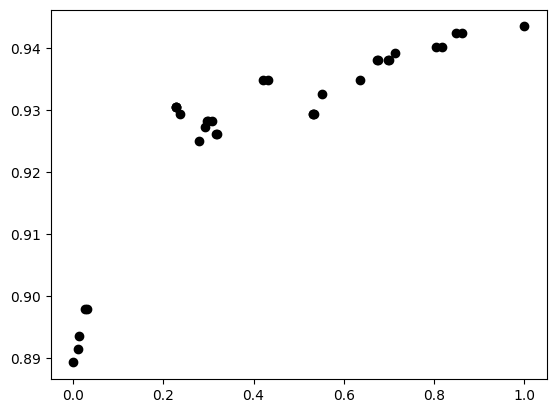

In [79]:
## What value of i (i.e. class weights) gives us the deferral rate we are looking for?
m = 300  ## "resolution" of targeting specific deferral rates
ptr = 0  ## We assume the deferral rates are strictly increasing -- not "guaranteed" to be true, but still a safe assumption
ptr_set = set()
fig, ax = plt.subplots()
for target_deferral_rate in np.linspace(0, 1, m):
    deferral_rate = results[ptr, 0, 1]
    while deferral_rate < target_deferral_rate:
        ptr += 1
        deferral_rate = results[ptr, 0, 1]
    
    if ptr not in ptr_set:
        ax.scatter(x=results[ptr, 1, 1], y=results[ptr, 1, 0], c='black')
        ptr_set.add(ptr)
    
plt.show();

In [6]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [7]:
X, y = load_dataset(94)  # Spambase
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape

(3680, 57)

In [8]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

0.9127717391304347

In [9]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

0.9967391304347826